Run these install commands in PowerShell if you don't have the packages:
```powershell
pip install scikit-learn pandas matplotlib
```

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Load the dataset (place this notebook in the same folder as salaries2.csv or give full path)
df = pd.read_csv('salaries2.csv')
df.head()

,company,job,degree,salary_more_then_100k
0,google,sales executive,bachelors,0
1,google,sales executive,masters,0
2,google,business manager,bachelors,1
3,google,business manager,masters,1
4,google,computer programmer,bachelors,0


In [2]:
# Encode categorical columns to numeric labels (this dataset uses company, job, degree)
le_company = LabelEncoder()
le_job = LabelEncoder()
le_degree = LabelEncoder()
df['company_n'] = le_company.fit_transform(df['company'])
df['job_n'] = le_job.fit_transform(df['job'])
df['degree_n'] = le_degree.fit_transform(df['degree'])
X = df[['company_n','job_n','degree_n']]
y = df['salary_more_then_100k']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
# Pre-pruning example: limit tree growth with max_depth and min_samples_leaf
from sklearn import tree
from sklearn.metrics import accuracy_score
pre_tree = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=1)
pre_tree.fit(X_train, y_train)
print('Pre-pruned accuracy:', accuracy_score(y_test, pre_tree.predict(X_test)))

Pre-pruned accuracy: 0.75


In [5]:
# Post-pruning (cost-complexity pruning) example
import numpy as np
full_tree = tree.DecisionTreeClassifier(random_state=1)
full_tree.fit(X_train, y_train)
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
# remove zero alpha if present (it corresponds to the unpruned tree)
ccp_alphas = ccp_alphas[ccp_alphas > 0]
clfs = []
test_scores = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
# pick best alpha by test accuracy (or use CV/validation set in practice)
best_idx = int(np.argmax(test_scores)) if len(test_scores) > 0 else None
if best_idx is not None:
    best_alpha = ccp_alphas[best_idx]
    print('Best ccp_alpha:', best_alpha, 'test accuracy:', test_scores[best_idx])
    pruned_tree = tree.DecisionTreeClassifier(random_state=1, ccp_alpha=best_alpha)
    pruned_tree.fit(X_train, y_train)
    print('Pruned tree test accuracy:', accuracy_score(y_test, pruned_tree.predict(X_test)))
else:
    print('No positive ccp_alpha values found; tree cannot be post-pruned with positive alpha on this data.')

Best ccp_alpha: 0.05555555555555555 test accuracy: 0.75
Pruned tree test accuracy: 0.75


Matplotlib is building the font cache; this may take a moment.


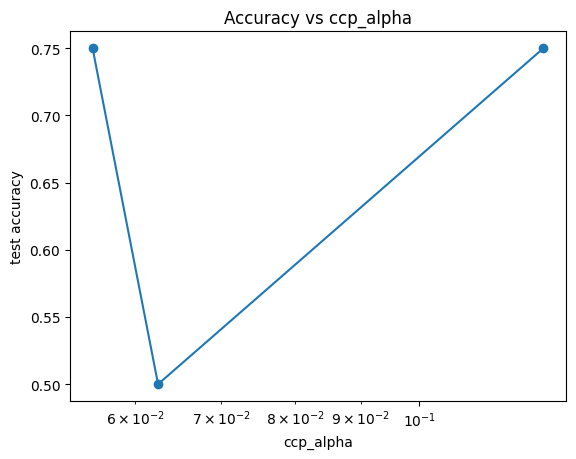

In [7]:
# Optional: visualize accuracy vs ccp_alpha
import matplotlib.pyplot as plt
if len(ccp_alphas) > 0:
    plt.plot(ccp_alphas, test_scores, marker='o')
    plt.xlabel('ccp_alpha')
    plt.ylabel('test accuracy')
    plt.title('Accuracy vs ccp_alpha')
    plt.xscale('log')
    plt.show()
else:
    print('No ccp_alphas to plot.')

**Notes:**
- Pre-pruning: set `max_depth`, `min_samples_leaf`, and `min_samples_split` to limit growth early.
- Post-pruning: `cost_complexity_pruning_path` returns candidate `ccp_alpha` values to prune weakest links; select an alpha using cross-validation for best generalization.
- For categorical data passed directly, use specialized libraries (CatBoost, LightGBM) — pruning concepts still apply but parameters differ (e.g., `max_depth`, `num_leaves`, regularization).